In [69]:
import asyncio
import numpy as np
from scipy.spatial.transform import Rotation as R

import time

from intrepid_environment.simulator import Simulator

In [70]:
import genesis as gs

In [71]:
import logging

In [72]:
gs.init(backend=gs.gpu, logging_level=logging.ERROR)

GenesisException: Genesis already initialized.

In [ ]:
viewer_options = gs.options.ViewerOptions(
    camera_pos=(2.5, 0.0, 1.5),
    camera_lookat=(0.0, 0.0, 0.5),
    camera_fov=30,
    max_FPS=600,
)

In [ ]:
DT_S = 0.001

In [ ]:
scene = gs.Scene(
    sim_options=gs.options.SimOptions(
        dt=DT_S,
    ),
    viewer_options=viewer_options,
    show_viewer=True,
)

In [ ]:
plane = scene.add_entity(
    gs.morphs.Plane(),
)

In [ ]:
drone = scene.add_entity(
    morph=gs.morphs.Drone(
        file="urdf/drones/cf2x.urdf",
        pos=(0.0, 0, 0.02),
    ),
)

In [ ]:
scene.build()

In [ ]:
def reset():
    drone.set_pos(np.array([0, 0, 0.02]), zero_velocity=True)
    drone.set_quat(np.array([1, 0, 0, 0]), zero_velocity=True)
    drone.zero_all_dofs_velocity()
    scene.step(update_visualizer=False)

In [ ]:
reset()

Setup trajectory for drone to follow.

In [ ]:
from quadcopter_control.trajectory import Trajectory, TrajectoryPoint

In [ ]:
newton_to_rpm = 14468.429183500699 / (9.81 * 0.027 / 4); newton_to_rpm

218498.57188055574

In [ ]:
# R_enu_to_ned = R.from_euler('z', -90, degrees=True) * R.from_euler('x', 180, degrees=True)
R_flip = np.array([
    [-1, 0 , 0],
    [0, 1 ,0],
    [0, 0, -1]
])

def sim_step(motors):

    # newton to rpm
    drone.set_propellels_rpm(np.array(motors))
    scene.step()

    position = R_flip @ drone.get_pos().cpu().numpy()
    velocity = R_flip @ drone.get_vel().cpu().numpy()
    attitude = R.from_quat(drone.get_quat().cpu().numpy(), scalar_first=True)
    # attitude = R.from_matrix((R_flip @ attitude.as_matrix()))
    omega    = R_flip @ drone.get_ang().cpu().numpy()

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [ ]:
def get_trajectory_with_initial_position():
    state = sim_step([0, 0, 0, 0])

    starting_point = TrajectoryPoint(
        time=0,
        acceleration=np.zeros(3),
        attitude=state['attitude'],
        omega=state['omega'],
        position=state['position'],
        velocity=state['velocity'],
    )

    trajectory = Trajectory()
    trajectory.add_point(starting_point)

    return trajectory

In [ ]:
trajectory_time_offset = 0
dp = np.zeros(3)

def get_next_trajectory_point(trajectory, sim_time, dt, dp):
    pt = trajectory.next_trajectory_point((sim_time + dt) / 1000.0)
    pt.position += dp
    return pt

In [ ]:
Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

In [ ]:
## Scenario 1: Altitude Control

# Tune gains until drone stays in place. on a desired height.

In [ ]:
reset()
state = sim_step([0, 0, 0, 0])
trajectory = get_trajectory_with_initial_position()

In [ ]:
sim_time = 0.0
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + DT_S),
        position=np.array([7.0, -3.0, 5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.1, 0.1, 0.1])
    ))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
DRONE_MASS = 0.027

In [ ]:
from tqdm import tqdm

In [ ]:
def tune_controller(
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=n_episodes,
):
    reset()
    scene.step()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    accelerations = []
    attitudes = []
    bx_cmds = []
    by_cmds = []
    bx_errs = []
    by_errs = []
    des_accs = []
    des_omegas = []
    est_omegas = []
    thrusts = []

    state = sim_step([0, 0, 0, 0])

    t = 0
    for _ in tqdm(range(n_episodes)):
        traj_pt = trajectory.next_trajectory_point(t)

        motors, (thrust, bx_cmd, by_cmd, bx_err, by_err, des_acc, des_omega) = quadcopter_controller.run_control(
            traj_pt,
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'])
        bx_cmds.append(bx_cmd)
        by_cmds.append(by_cmd)
        bx_errs.append(bx_err)
        by_errs.append(by_err)
        des_accs.append(des_acc)
        des_omegas.append(des_omega)
        est_omegas.append(state['omega'])
        thrusts.append(thrust)

        # motors = np.clip(motors, 40, 500) * ne
        positions.append(state['position'])
        times.append(t)
        try:
            state = sim_step(motors * newton_to_rpm)
        except:
            break

        t += DT_S

    return (
        np.array(times), 
        np.array(positions), 
        # np.array(accelerations),
        np.array(attitudes),
        np.array(bx_cmds), 
        np.array(by_cmds), 
        np.array(bx_errs), 
        np.array(by_errs), 
        np.array(des_accs), 
        np.array(des_omegas),
        np.array(est_omegas),
        np.array(thrusts),
    )

## Scenario 2: Position Control


In [73]:
class QuadcopterController:
    """
    coordinate system: bevy: right-handed, y-top
    """

    def __init__(self, dt, mass, Ixx, Iyy, Izz, max_tilt_angle, max_accel_xy, max_vel_xy, max_ascent_rate, l=np.sqrt(2)):

        self.dt = dt

        # drone physical parameters
        self.max_tilt_angle = max_tilt_angle
        self.max_ascent_rate = max_ascent_rate

        self.mass = mass
        self.Ixx = Ixx
        self.Iyy = Iyy
        self.Izz = Izz

        self.kappa = 1.0  # velociy/thrust ratio
        self.max_motor_thrust = 0.26477955 / 4 * 1.5
        self.min_motor_thrust = 0.26477955 / 4 * 0.9
        self.max_accel_xy = max_accel_xy
        self.max_vel_xy = max_vel_xy
        self.l = l

        # controller errors
        self.integrated_altitude_error = 0.0
        self.set_gains()

    def set_gains(self, kp_pqr=0.0, kp_bank=0.0, kp_pos_z=0.0, kp_vel_z=0.0,
                  ki_pos_z=0.0, kp_pos_xy=0.0, kp_yaw=0.0, kp_vel_xy=0.0,
                  kappa=1.0):
        self.kp_pqr = kp_pqr
        self.kp_bank = kp_bank
        self.kp_pos_z = kp_pos_z
        self.kp_vel_z = kp_vel_z
        self.ki_pos_z = ki_pos_z
        self.kp_pos_xy = kp_pos_xy
        self.kp_yaw = kp_yaw
        self.kp_vel_xy = kp_vel_xy
        self.kappa = kappa

    def body_rate_control(self, pqr_cmd, pqr):
        """
        Calculate a desired 3-axis moment given a desired and current body rate

        Args:
          pqr_cmd: desired body rates [rad/s]
          pqr: current or estimated body rates [rad/s]

        Returns:
          A 3x1 numpy array containing the desired moments for each of the 3 axes.
        """

        I = np.diag([self.Ixx, self.Iyy, self.Izz])
        pqr_err = (pqr_cmd - pqr)
        moment_cmd = self.kp_pqr * (I @ pqr_err)

        return moment_cmd

    def altitude_control(self, pos_z_cmd, vel_z_cmd, pos_z, vel_z, attitude, accel_z_cmd, dt):
        """
        Calculate desired quad thrust based on altitude setpoint, actual altitude,
          vertical velocity setpoint, actual vertical velocity, and a vertical
          acceleration feed-forward command

        Args:
          pos_z_cmd, vel_z_cmd: desired vertical position and velocity in NED [m]
          pos_z, vel_z: current vertical position and velocity in NED [m]
          accel_z_cmd: feed-forward vertical acceleration in NED [m/s2]
          dt: the time step of the measurements [seconds]

        Returns:
          A collective thrust command in [N]
        """

        R = attitude.as_matrix()

        pos_z_err = pos_z_cmd - pos_z
        vel_z_err = vel_z_cmd - vel_z
        self.integrated_altitude_error += pos_z_err * dt

        b_z = R[2, 2]

        p_term = self.kp_pos_z * pos_z_err
        d_term = self.kp_vel_z * vel_z_err
        i_term = self.ki_pos_z * self.integrated_altitude_error

        u1_bar = p_term + i_term + d_term + accel_z_cmd

        acc = (u1_bar - 9.81) / b_z

        # print("thust", -self.mass * acc)

        # clipped_acc = np.clip(
        #     acc,
        #     -self.max_ascent_rate / dt,
        #     +self.max_ascent_rate / dt
        # )

        return -self.mass * acc

    def roll_pitch_control(self, accel_cmd, attitude, thrust):
        pqr_cmd = np.zeros(3)
        R = attitude.as_matrix()
        if thrust == 0:
            return pqr_cmd

        coll_accel = -thrust / self.mass

        bx_cmd = np.clip(
            accel_cmd[0] / coll_accel,
            -self.max_tilt_angle,
            +self.max_tilt_angle
        )
        by_cmd = np.clip(
            accel_cmd[1] / coll_accel,
            -self.max_tilt_angle,
            +self.max_tilt_angle
        )

        bx_err = (bx_cmd - R[0, 2])
        by_err = (by_cmd - R[1, 2])

        bx_p_term = self.kp_bank * bx_err
        by_p_term = self.kp_bank * by_err

        r11 = +R[1, 0] / R[2, 2]
        r12 = -R[0, 0] / R[2, 2]
        r21 = +R[1, 1] / R[2, 2]
        r22 = -R[0, 1] / R[2, 2]

        pqr_cmd[0] = r11 * bx_p_term + r12 * by_p_term
        pqr_cmd[1] = r21 * bx_p_term + r22 * by_p_term

        return pqr_cmd, (bx_cmd, by_cmd, bx_err, by_err)

    def lateral_position_control(self, pos_cmd, vel_cmd, pos, vel, accel_cmd_ff):
        """
        Calculate a desired horizontal acceleration based on
          desired lateral position/velocity/acceleration and current pose

        Args:
          pos_cmd: desired position, in NED [m]
          vel_cmd: desired velocity, in NED [m/s]
          pos: current position, NED [m]
          vel: current velocity, NED [m/s]
          accel_cmd_ff: feed-forward acceleration, NED [m/s2]

        Returns:
          A 3x1 numpy array with desired horizontal accelerations.
            the Z component should be 0
        """

        accel_cmd_ff[2] = 0
        vel_cmd[2] = 0
        pos_cmd[2] = pos[2]

        accel_cmd = accel_cmd_ff

        pos_err = pos_cmd - pos
        vel_err = vel_cmd - vel

        accel = self.kp_pos_xy * pos_err + self.kp_vel_xy * vel_err + accel_cmd_ff
        accel_cmd[0] = accel[0]
        accel_cmd[1] = accel[1]

        return accel_cmd

    def yaw_control(self, yaw_cmd, yaw):
        """
        Calculate a desired yaw rate to control yaw to yawCmd

        Args:
          yaw_cmd: commanded yaw [rad]
          yaw: current yaw [rad]

        Returns:
          a desired yaw rate [rad/s]
        """

        yaw_rate_cmd = self.kp_yaw * (yaw_cmd - yaw)
        return yaw_rate_cmd

    def generate_motor_commands(self, coll_thrust_cmd, moment_cmd):
        """
        Convert a desired 3-axis moment and collective thrust command to
          individual motor thrust commands

        Args:
          coll_thrust_cmd: desired collective thrust [N]
          moment_cmd: desired rotation moment about each axis [N m]

        Returns:
          a 4-vec with motor commands
        """

        l = self.l / np.sqrt(2.0)

        t1 = moment_cmd[0] / l
        t2 = moment_cmd[1] / l
        t3 = -moment_cmd[2] / self.kappa
        t4 = coll_thrust_cmd

        thrust = np.array([
            (+t1 + t2 + t3 + t4) / 4.0,  # front left  - f1
            (-t1 + t2 - t3 + t4) / 4.0,  # front right - f2
            (+t1 - t2 - t3 + t4) / 4.0,  # rear left   - f4
            (-t1 - t2 + t3 + t4) / 4.0,  # rear right  - f3
        ])

        return thrust

    def run_control(self, traj_pt, est_pos, est_vel, est_omega, est_att):
        (
            t_pos,
            t_vel,
            t_acc,
            t_att,
        ) = traj_pt.position, traj_pt.velocity, traj_pt.acceleration, traj_pt.attitude

        thrust = self.altitude_control(
            t_pos[2],
            t_vel[2],
            est_pos[2],
            est_vel[2],
            est_att,
            t_acc[2],
            self.dt
        )

        thrust_margin = 0.1 * (self.max_motor_thrust - self.min_motor_thrust)
        thrust = np.clip(
            thrust,
            (self.min_motor_thrust + thrust_margin) * 4.0,
            (self.max_motor_thrust - thrust_margin) * 4.0
        )

        des_acc = self.lateral_position_control(
            np.copy(t_pos),
            np.copy(t_vel),
            np.copy(est_pos),
            np.copy(est_vel),
            np.copy(t_acc)
        )

        # des_acc = np.clip(
        #     des_acc,
        #     -self.max_accel_xy,
        #     +self.max_accel_xy,
        # )

        des_omega, (bx_cmd, by_cmd, bx_err, by_err) = self.roll_pitch_control(
            des_acc, est_att, thrust)

        traj_euler_angles = t_att.as_euler('zyx', degrees=False)
        traj_yaw = traj_euler_angles[0]
        est_yaw = est_att.as_euler('zyx', degrees=False)[0]
        des_omega[2] = self.yaw_control(traj_yaw, est_yaw)

        des_moment = self.body_rate_control(des_omega, est_omega)

        return (
            self.generate_motor_commands(thrust, des_moment),
            (thrust, bx_cmd, by_cmd, bx_err, by_err, des_acc, des_omega),
        )

In [74]:
quadcopter_controller = QuadcopterController(
    DT_S,
    0.027 * 0.99,
    Ixx, Iyy, Izz,
    l=0.030,
    max_tilt_angle=0.7,
    max_ascent_rate=5.0,
    max_vel_xy=5,
    max_accel_xy=12,
)

In [122]:
reset()

In [130]:
# entity = await restart_drone()
state = sim_step([0, 0, 0, 0])
trajectory = get_trajectory_with_initial_position()

sim_time = 0
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=sim_time + i*DT_S,
        position=np.array([-0.001, 0.0, -5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.0, 0.0, 0.0])
    ))

In [131]:
def sim_step(motors):

    # newton to rpm
    drone.set_propellels_rpm(np.array(motors))
    scene.step()

    position = drone.get_pos().cpu().numpy()
    velocity = drone.get_vel().cpu().numpy()
    attitude = R.from_quat(drone.get_quat().cpu().numpy(), scalar_first=True)
    omega    = drone.get_ang().cpu().numpy()

    position[2] *= -1
    velocity[2] *= -1

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [ ]:
(times,
 positions,
 attitudes,
 bx_cmds, by_cmds,
 bx_errs, by_errs,
 des_accs, des_omegas, est_omegas,
 thrusts) = tune_controller(
    kp_pqr=np.array([0.9, 0.91, 0.9]),
    ki_pos_z=.01,
    kp_pos_z=0.8,
    kp_vel_z=0.8,
    kp_pos_xy=0.2,
    kp_vel_xy=0.2,
    kp_yaw=1.0,
    kp_bank=0.02,
    n_episodes=5000,
)

100%|██████████| 5000/5000 [00:23<00:00, 214.62it/s]


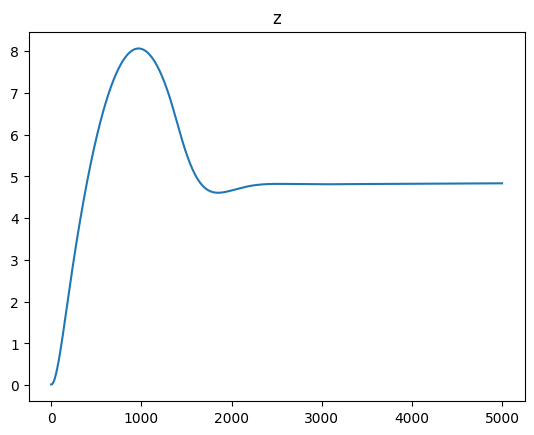

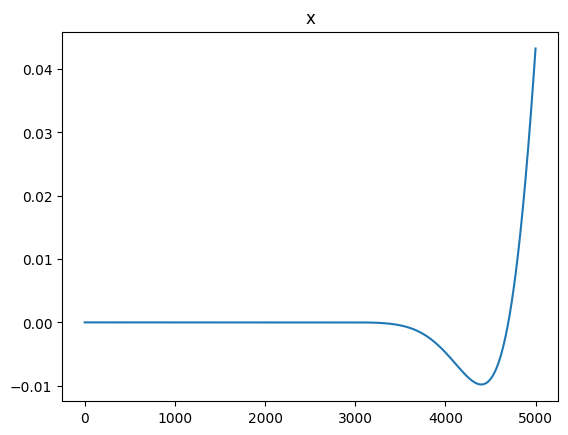

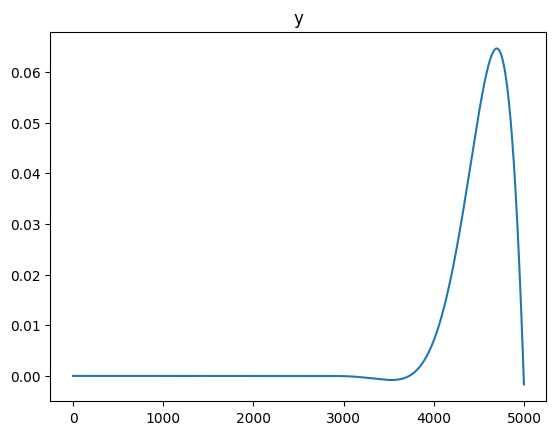

In [134]:
plt.title("z")
plt.plot(-positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()